<!-- # Overview
- Project
    - data engineer 
        - keep acceptable sessions
        - create prediction classes and eliminate end of each session
        - make same input size for rnn
        - add features if this is suitable
    - code each rnn
        - vanilla rnn
        - lstm
        - gru -->

# Overview
- Modelling
    - Train-Test-Split
    - RNN
        - Model Def
        - Model Training
        - Model Evaluation
    - LSTM
        - Model Def
        - Model Training
        - Model Evaluation
    - GRU
        - Model Def
        - Model Training
        - Model Evaluation

# Imports

In [16]:
# manipulating data
import numpy as np

# 
from sklearn.utils.class_weight import compute_class_weight

# Neural Networks
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim

# Custom Metrics and Evaluation
from metrics import bin_class_metrics, multiclass_metrics, evaluate_model_metrics, print_metrics, PlotLoss
from ModelDefinitions import RNNClassifier, LSTMClassifier, GRUClassifier
from TrainFunctions import create_file, load_data, getDataloaders, train_model

# handling time data
import time # for counting time for something to run

# plotting
import matplotlib.pyplot as plt 

# handling files
import os


# Modelling

### Global Parameters

In [101]:
# select GPU / CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Train RNN

In [390]:
# parameters
model_name = "vanilla_rnn"
output_size = 3
train_dataset, test_dataset = load_data(output_size)

input_size = len(train_dataset[0][0][0])
b = 32 # batch size
h = 64 # hidden size
d = 0  # dropout
learning_rate = 0.001
bias = True
n_layers = 1

train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

class_weights=compute_class_weight('balanced',classes = np.unique(train_dataset[:][1]), y = train_dataset[:][1].numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

path = create_file(model_name, output_size, h, b)

# instantiate model
rnn = RNNClassifier(input_size, h, output_size, device, n_layers, d, bias).to(device)
rnn = nn.DataParallel(rnn)

loss_fn_rnn = torch.nn.CrossEntropyLoss(weight = class_weights) # 
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_rnn = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

rnn_val_loss_tot = []
rnn_train_loss_tot = []


In [419]:
# train
num_epochs = 8
rnn, rnn_train_loss, rnn_val_loss = train_model(rnn, loss_fn_rnn, optimizer_rnn, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
rnn_val_loss_tot.append(rnn_val_loss)
rnn_train_loss_tot.append(rnn_train_loss)

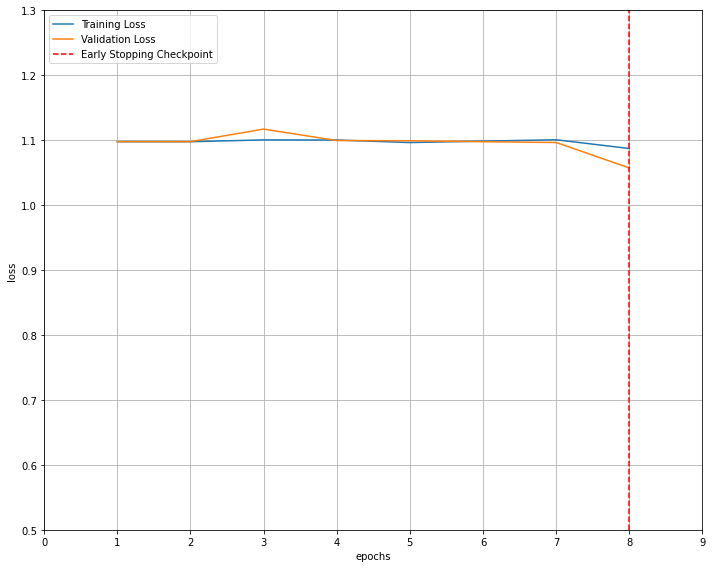

In [410]:
PlotLoss(rnn_train_loss, rnn_val_loss, model_name)

In [392]:
print_metrics(rnn, model_name, output_size, train_dataloader, test_dataloader, device)

-----------------------------------------------------------------------------------
VANILLA_RNN  Metrics
Test
Confusion Matrix (0 in Top Left): 
[[20399 12159   355]
 [ 2327  2994   721]
 [  630   744   296]]
F1-Score (Average) tensor(0.3975)
F1-Score (each):
Class  0 : tensor(0.7251)
Class  1 : tensor(0.2729)
Class  2 : tensor(0.1946)
tensor([0.7251, 0.2729, 0.1946])


(tensor(0.3975), tensor([0.7251, 0.2729, 0.1946]))

## Train LSTM

In [360]:
# parameters
model_name = "lstm"
output_size = 3

train_dataset, test_dataset = load_data(output_size)

input_size = len(train_dataset[0][0][0])
b = 32 # batch size
h = 64 # hidden size
learning_rate = 0.001
bias = True
d = 0.3
n_layers = 1

train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

class_weights=compute_class_weight('balanced', classes = np.unique(train_dataset[:][1]), y = train_dataset[:][1].numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

path = create_file(model_name, output_size, h, b)

# instantiate model
lstm = LSTMClassifier(input_size, h, output_size, device, n_layers, d, bias).to(device)
lstm = nn.DataParallel(lstm)

loss_fn_lstm = torch.nn.CrossEntropyLoss(weight = class_weights) # weight = class_weights
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstm_val_loss_tot = []
lstm_train_loss_tot = []


In [421]:
# train
num_epochs = 8
lstm, lstm_train_loss, lstm_val_loss = train_model(lstm, loss_fn_lstm, optimizer_lstm, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
lstm_val_loss_tot.append(lstm_val_loss)
lstm_train_loss_tot.append(lstm_train_loss)

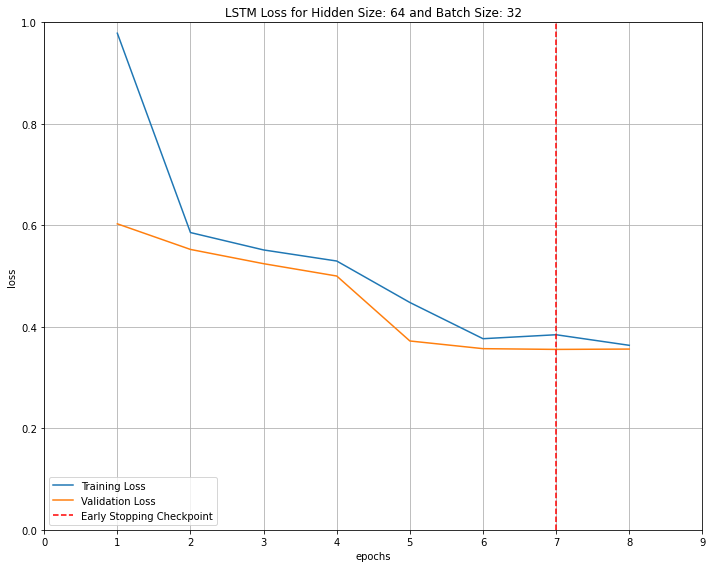

In [417]:
PlotLoss(lstm_train_loss, lstm_val_loss, model_name)

In [287]:
# 64 - 64 - less_cols, class_weights
print_metrics(lstm, model_name, output_size, train_dataloader, test_dataloader, device)

-----------------------------------------------------------------------------------
LSTM  Metrics
Test
Confusion Matrix (0 in Top Left): 
[[32238    14   661]
 [   19  5543   480]
 [  107   175  1388]]
F1-Score (Average) tensor(0.8635)
F1-Score (each):
Class  0 : tensor(0.9877)
Class  1 : tensor(0.9416)
Class  2 : tensor(0.6611)
tensor([0.9877, 0.9416, 0.6611])


(tensor(0.8635), tensor([0.9877, 0.9416, 0.6611]))

## Train GRU

In [330]:
# choose which problem to solve
output_size = 3

# get datasets
train_dataset, test_dataset = load_data(output_size)

# parameters
input_size = len(train_dataset[0][0][0])
n_layers = 1
model_name = "gru"
b = 16 # batch size
h = 64 # hidden size
learning_rate = 0.001
bias = True
d = 0.2

# get class weights for imbalanced datasets
y = train_dataset[:][1]
class_weights=compute_class_weight('balanced', classes = np.unique(y), y = y.numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

# create path to store checkpoints
path = create_file(model_name, output_size, h, b)

# get dataloaders
train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

# instantiate model
gru = GRUClassifier(input_size, h, output_size, device, n_layers, d, bias).to(device)
gru = nn.DataParallel(gru)

loss_fn_gru = torch.nn.CrossEntropyLoss(weight = class_weights) 
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_gru = torch.optim.Adam(gru.parameters(), lr=learning_rate)

gru_val_loss_tot = []
gru_train_loss_tot = []


In [422]:
# train
num_epochs = 12
gru, gru_train_loss, gru_val_loss = train_model(gru, loss_fn_gru, optimizer_gru, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
gru_val_loss_tot.append(gru_val_loss)
gru_train_loss_tot.append(gru_train_loss)

In [ ]:
gru_train_loss_tot = [item for sublist in gru_train_loss_tot for item in sublist]
gru_val_loss_tot = [item for sublist in gru_val_loss_tot for item in sublist]

PlotLoss(gru_train_loss_tot, gru_val_loss_tot, model_name + "extraLinear")

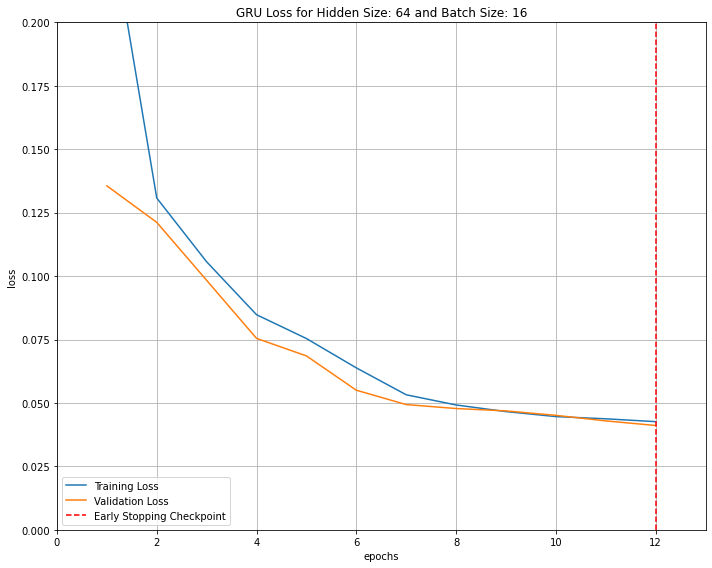

In [184]:
gru_train_loss_tot = [item for sublist in gru_train_loss_tot for item in sublist]
gru_val_loss_tot = [item for sublist in gru_val_loss_tot for item in sublist]

PlotLoss(gru_train_loss_tot, gru_val_loss_tot, model_name)

In [216]:
#64 - 16
print_metrics(gru, model_name, output_size, train_dataloader, test_dataloader, device)

-----------------------------------------------------------------------------------
GRU  Metrics
Test
Confusion Matrix (0 in Top Left): 
[[32887     0    26]
 [    6  5729   307]
 [  202   106  1362]]
F1-Score (Average) tensor(0.9236)
F1-Score (each):
Class  0 : tensor(0.9965)
Class  1 : tensor(0.9647)
Class  2 : tensor(0.8095)
tensor([0.9965, 0.9647, 0.8095])


(tensor(0.9236), tensor([0.9965, 0.9647, 0.8095]))